In [128]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt             
import matplotlib as mpl                    
mpl.rc('font', family='Malgun Gothic')      
plt.rcParams['axes.unicode_minus']=False  

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras     
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam

from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import LambdaCallback


import FinanceDataReader as fdr
from tensorflow.keras.layers import LSTM

# 삼성전자 주식 예측

## 데이터 로드

In [132]:
samsung=fdr.DataReader('005930', '2020')    # 삼성전자 
samsung.shape
samsung.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,55500,56000,55000,55200,12993228,-0.010753
2020-01-03,56000,56600,54900,55500,15422255,0.005435
2020-01-06,54900,55600,54600,55500,10278951,0.000000
2020-01-07,55700,56400,55600,55800,10009778,0.005405
2020-01-08,56200,57400,55900,56800,23501171,0.017921


In [134]:
seq_data=samsung[['Close']]
seq_data.head()

,Close
Date,
2020-01-02,55200
2020-01-03,55500
2020-01-06,55500
2020-01-07,55800
2020-01-08,56800


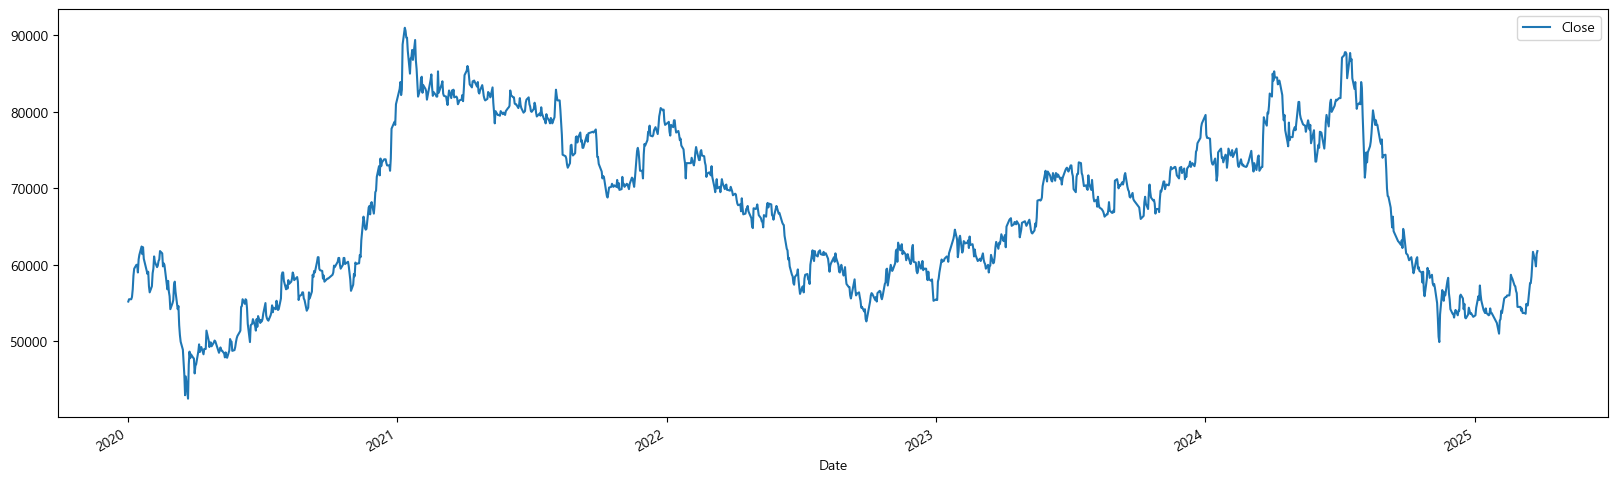

In [136]:
ax=seq_data.plot()
fig=ax.get_figure()
fig.set_size_inches(20, 6) 

## Sliding Window 
- 시간 순서대로 데이터를 일정한 크기로 자르면서 이동하는 기법 

In [139]:
data=np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
print(len(data), type(data))

def imsi(data, window):
    train=[]
    target=[]

    for i in range(len(data) - window):   # 10 - 3 = 7 / range(0, 7)
        # print("idx:", i) 
        
        train.append(data[i: i+window])   # 0:3 [1, 2, 3], 1:4 [2, 3, 4]
  # print("train:", train)

        target.append(data[i + window])    # 3, 4
  # print("target:", target)             
        
    return np.array(train), np.array(target)    


X, Y=imsi(data, 3)
print(X)
print(Y)
X.shape, Y.shape

10 <class 'numpy.ndarray'>
[[1 2 3]
 [2 3 4]
 [3 4 5]
 [4 5 6]
 [5 6 7]
 [6 7 8]
 [7 8 9]]
[ 4  5  6  7  8  9 10]


((7, 3), (7,))

## 데이터 전처리
### MinMaxScaler

In [142]:
min_max_scaler=MinMaxScaler()
min_max_scaled=min_max_scaler.fit_transform(seq_data)

In [144]:
train_data, test_data=train_test_split(min_max_scaled, test_size=0.2, shuffle=False)
print(train_data.shape, test_data.shape)

(1029, 1) (258, 1)


###  Sliding Window 

In [147]:
def make_sample(data, window):
    train=[]
    target=[]

    for i in range(len(data) - window):
        train.append(data[i: i+window])
        target.append(data[i + window])
    return np.array(train), np.array(target)

X_train, Y_train=make_sample(train_data, 30)
X_train.shape, Y_train.shape

((999, 30, 1), (999, 1))

### 학습

In [150]:
model=keras.Sequential()
model.add(keras.layers.Input(shape=(30, 1)))                                  # LSTM 입력 크기
model.add(keras.layers.LSTM(16, activation='tanh', return_sequences=False))   # 시퀀스 중 마지막 상태만 출력 (회귀)
model.add(keras.layers.Dense(1))                                              # 출력층
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,169 (4.57 KB)

 Trainable params: 1,169 (4.57 KB)

 Non-trainable params: 0 (0.00 B)

In [170]:
def on_epoch_end_fun(epoch, logs):  
    if(epoch + 1) % 10 == 0:
       print(f"Epoch {epoch+1}: loss={logs['loss']:.4f}, mse={logs['mse']:.4f}")

# 각 에포크가 끝날 때 on_epoch_end 함수
print_callback=LambdaCallback(on_epoch_end=on_epoch_end_fun)

# 학습 중단
early_stopping_callback=EarlyStopping(monitor='loss',       
                                      patience=20,                # 20 epoch 동안 개선이 없으면 학습 중단
                                      verbose=1,                   # early stopping 메시지 출력  
                                      restore_best_weights=True)   # 가장 좋은 가중치 복원              

In [172]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.fit(X_train, Y_train,  epochs=20, batch_size=16,  verbose=0, callbacks=[print_callback, early_stopping_callback])
# model.fit(X, Y,  epochs=100, batch_size=16)

Epoch 10: loss=0.0008, mse=0.0008
Epoch 20: loss=0.0007, mse=0.0007
Restoring model weights from the end of the best epoch: 20.


### 평가

In [156]:
X_test, Y_test=make_sample(test_data, 30)
pred=model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


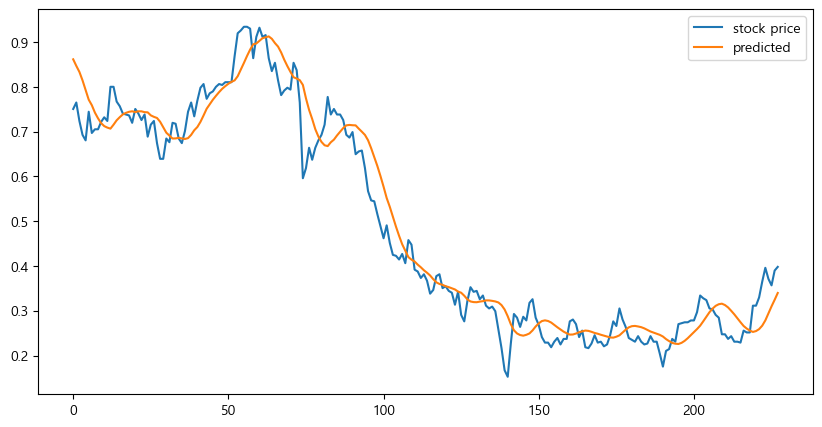

In [157]:
plt.figure(figsize=(10, 5))
plt.plot(Y_test, label='stock price')
plt.plot(pred, label='predicted')
plt.legend()
plt.show()

In [163]:
r2=r2_score(Y_test, pred)
print("R² Score:", r2)

R² Score: 0.9494115355854408


In [165]:
# 최근 30일 데이터를 사용해 다음날 가격 예측
last_sequence=X_test[-1:]     # 마지막 1개의 샘플, 이미 (1, 30, 1) 형태
last_sequence

# 예측 수행
predicted_price=model.predict(last_sequence)
print(predicted_price)

# 원래 가격대로 변환 (역정규화)
predicted_price=min_max_scaler.inverse_transform(predicted_price)
print(predicted_price)

print(f"예측된 다음날 가격: {predicted_price[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
[[0.3396578]]
[[58973.402]]
예측된 다음날 가격: 58973.40


In [167]:
seq_data.tail(1)

,Close
Date,
2025-03-27,61800


# 마트 상품
- 기저귀 금액 예측

## 데이터 불러오기

In [465]:
mart=pd.read_csv('./../../workspace/MachineLearning/Data/supervised/mart_diaper.csv')
mart.shape

(585, 2)

In [467]:
mart.head()

,구매일,구매금액
0,2019-01-01,3051240
1,2019-01-02,2556280
2,2019-01-03,2729480
3,2019-01-04,2238440
4,2019-01-05,2478680


In [469]:
mart.set_index('구매일', inplace=True)

In [471]:
mart.head()

,구매금액
구매일,
2019-01-01,3051240
2019-01-02,2556280
2019-01-03,2729480
2019-01-04,2238440
2019-01-05,2478680


## 데이터 전처리

In [474]:
min_max_scaler=MinMaxScaler()
min_max_scaled=min_max_scaler.fit_transform(mart)

In [476]:
train_data, test_data=train_test_split(min_max_scaled, test_size=0.2, shuffle=False)
train_data.shape, test_data.shape

((468, 1), (117, 1))

In [478]:
def make_sample(data, window):
    train=[]
    target=[]

    for i in range(len(data) - window):
        train.append(data[i:i + window])
        target.append(data[i + window])
    return np.array(train), np.array(target)

In [480]:
X_train, Y_train=make_sample(train_data, 7)
X_train.shape, Y_train.shape

((461, 7, 1), (461, 1))

## 학습

In [483]:
model=keras.Sequential()
model.add(keras.layers.Input(shape=(X_train.shape[1], 1)))                     # LSTM 입력 크기
model.add(keras.layers.LSTM(16, activation='tanh', return_sequences=False))    # 시퀀스 중 마지막 상태만 출력 (회귀)
model.add(keras.layers.Dense(1))                                               # 출력층
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                       │ (None, 16)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,169 (4.57 KB)

 Trainable params: 1,169 (4.57 KB)

 Non-trainable params: 0 (0.00 B)

In [485]:
def on_epoch_end_fun(epoch, logs):  
    if(epoch + 1) % 10 == 0:
       print(f"Epoch {epoch+1}: loss={logs['loss']:.4f}, mse={logs['mse']:.4f}")
        
# 각 에포크가 끝날 때 on_epoch_end 함수
print_callback=LambdaCallback(on_epoch_end=on_epoch_end_fun)

# 학습 중단
early_stopping_callback=EarlyStopping(monitor='loss',       
                                      patience=50,                # 20 epoch 동안 개선이 없으면 학습 중단
                                      verbose=1,                   # early stopping 메시지 출력  
                                      restore_best_weights=True)   # 가장 좋은 가중치 복원    

In [487]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.fit(X_train, Y_train, epochs=200, batch_size=16, verbose=0, callbacks=[print_callback, early_stopping_callback])
# model.fit(X, Y,  epochs=100, batch_size=16)

Epoch 10: loss=0.0128, mse=0.0128
Epoch 20: loss=0.0120, mse=0.0120
Epoch 30: loss=0.0109, mse=0.0109
Epoch 40: loss=0.0093, mse=0.0093
Epoch 50: loss=0.0083, mse=0.0083
Epoch 60: loss=0.0081, mse=0.0081
Epoch 70: loss=0.0080, mse=0.0080
Epoch 80: loss=0.0080, mse=0.0080
Epoch 90: loss=0.0080, mse=0.0080
Epoch 100: loss=0.0079, mse=0.0079
Epoch 110: loss=0.0079, mse=0.0079
Epoch 120: loss=0.0079, mse=0.0079
Epoch 124: early stopping
Restoring model weights from the end of the best epoch: 74.


## 평가

In [489]:
X_test, Y_test=make_sample(test_data, 7)
pred=model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step


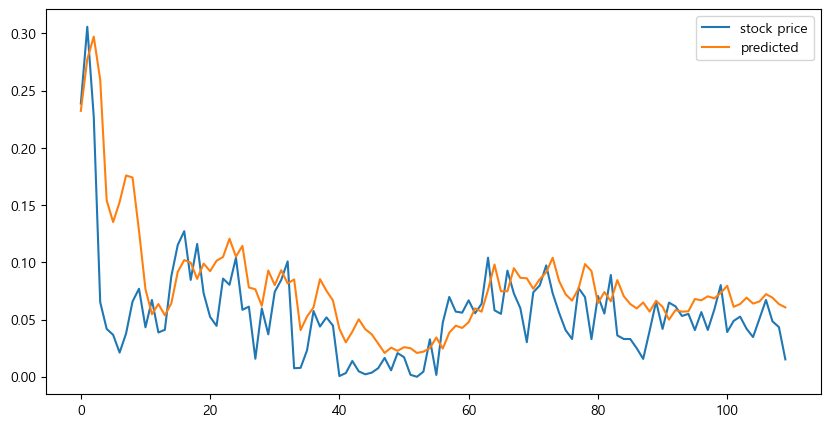

In [490]:
plt.figure(figsize=(10, 5))
plt.plot(Y_test, label='stock price')
plt.plot(pred, label='predicted')
plt.legend()
plt.show()

In [496]:
r2=r2_score(Y_test, pred)
r2

0.08031654540437916

In [498]:
# 최근 30일 데이터를 사용해 다음날 가격 예측
last_sequence=X_test[-1:]     # 마지막 1개의 샘플, 이미 (1, 30, 1) 형태
last_sequence

# 예측 수행
predicted_price=model.predict(last_sequence)
print(predicted_price)

# 원래 가격대로 변환 (역정규화)
predicted_price=min_max_scaler.inverse_transform(predicted_price)
print(predicted_price)

print(f"예측된 다음날 가격: {predicted_price[0][0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
[[0.06061624]]
[[3635716.8]]
예측된 다음날 가격: 3635716.75


In [500]:
mart.tail(1)

,구매금액
구매일,
2020-08-07,1022300


# 채소값 예측
- 농수산물, 기상청 데이터 수집

## 데이터 전처리
### 기상청 데이터

In [504]:
weather=pd.read_csv('./Data/weather.csv', encoding='cp949')
weather.shape

(1338, 5)

In [506]:
weather.head()

,날짜,지점,평균기온(℃),최저기온(℃),최고기온(℃)
0,2019-10-11,전국,17.7,11.4,24.7
1,2019-10-12,전국,17.8,13.3,23.1
2,2019-10-13,전국,15.6,10.3,22.0
3,2019-10-14,전국,14.4,9.0,21.2
4,2019-10-15,전국,13.1,8.3,18.6


In [508]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   날짜       1338 non-null   object 
 1   지점       1337 non-null   object 
 2   평균기온(℃)  1337 non-null   float64
 3   최저기온(℃)  1337 non-null   float64
 4   최고기온(℃)  1337 non-null   float64
dtypes: float64(3), object(2)
memory usage: 52.4+ KB


In [510]:
weather.rename(columns={
    '날짜': '조회일자',
    '평균기온(℃)': '평균기온',
    '최저기온(℃)': '최저기온',
    '최고기온(℃)': '최고기온'
}, inplace=True)

### 농수산물 데이터

In [513]:
price=pd.read_csv('./Data/price.csv', encoding='cp949')
price.shape

(9291, 4)

In [515]:
price.head()

,조회일자,품목코드,품목명,소매일일가격
0,2019-10-10,1201,양파,1308
1,2019-10-10,1202,대파,4164
2,2019-10-11,1001,배추,6968
3,2019-10-11,1101,무,2776
4,2019-10-11,1207,건고추,12756


In [517]:
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9291 entries, 0 to 9290
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   조회일자    9291 non-null   object
 1   품목코드    9291 non-null   int64 
 2   품목명     9291 non-null   object
 3   소매일일가격  9291 non-null   object
dtypes: int64(1), object(3)
memory usage: 290.5+ KB


### 기상청 + 농수산물 병합

In [520]:
join=pd.merge(weather, price, on='조회일자', how='left')

In [522]:
vegetable=join.copy()
vegetable.shape

(9300, 8)

In [524]:
vegetable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9300 entries, 0 to 9299
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   조회일자    9300 non-null   object 
 1   지점      9299 non-null   object 
 2   평균기온    9299 non-null   float64
 3   최저기온    9299 non-null   float64
 4   최고기온    9299 non-null   float64
 5   품목코드    9289 non-null   float64
 6   품목명     9289 non-null   object 
 7   소매일일가격  9289 non-null   object 
dtypes: float64(4), object(4)
memory usage: 581.4+ KB


In [526]:
vegetable['조회일자']=pd.to_datetime(vegetable['조회일자'])
vegetable['소매일일가격']=pd.to_numeric(vegetable['소매일일가격'], errors='coerce')

- coerce 변환할 수 없는 값이 있을 경우, 그 값을 **NaN**으로 처리

In [529]:
vegetable.dropna(inplace=True)

In [531]:
vegetable.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9288 entries, 0 to 9298
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   조회일자    9288 non-null   datetime64[ns]
 1   지점      9288 non-null   object        
 2   평균기온    9288 non-null   float64       
 3   최저기온    9288 non-null   float64       
 4   최고기온    9288 non-null   float64       
 5   품목코드    9288 non-null   float64       
 6   품목명     9288 non-null   object        
 7   소매일일가격  9288 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 653.1+ KB


In [533]:
vegetable.set_index('조회일자', inplace=True)
vegetable.head()

,지점,평균기온,최저기온,최고기온,품목코드,품목명,소매일일가격
조회일자,,,,,,,
2019-10-11,전국,17.7,11.4,24.7,1001.0,배추,6968.0
2019-10-11,전국,17.7,11.4,24.7,1101.0,무,2776.0
2019-10-11,전국,17.7,11.4,24.7,1207.0,건고추,12756.0
2019-10-11,전국,17.7,11.4,24.7,1209.0,마늘,7044.0
2019-10-11,전국,17.7,11.4,24.7,1209.0,마늘,0.0


In [535]:
vegetable.describe(include='object')
vegetable['품목명'].value_counts()

품목명
마늘     2653
배추     1327
무      1327
건고추    1327
양파     1327
대파     1327
Name: count, dtype: int64

<Axes: xlabel='조회일자', ylabel='소매일일가격'>

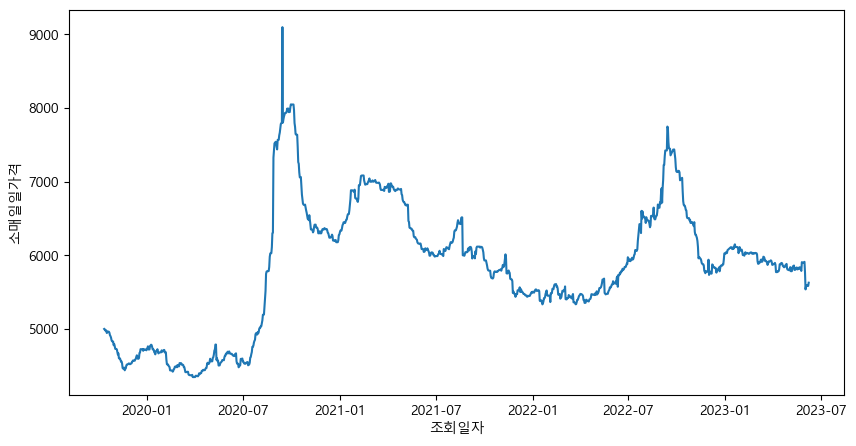

In [537]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=vegetable, x='조회일자', y='소매일일가격', errorbar=None)

### 품목 선택 - 배추

In [539]:
def get_product_data(product_name):
    cond=vegetable['품목명'] == product_name
    product_data=vegetable.loc[cond]
    return product_data

In [541]:
# kind=input("채소입력:")

In [543]:
cabbage=get_product_data('배추')
cabbage.shape

(1327, 7)

In [545]:
cabbage.head()

,지점,평균기온,최저기온,최고기온,품목코드,품목명,소매일일가격
조회일자,,,,,,,
2019-10-11,전국,17.7,11.4,24.7,1001.0,배추,6968.0
2019-10-12,전국,17.8,13.3,23.1,1001.0,배추,6968.0
2019-10-13,전국,15.6,10.3,22.0,1001.0,배추,6968.0
2019-10-14,전국,14.4,9.0,21.2,1001.0,배추,6826.0
2019-10-15,전국,13.1,8.3,18.6,1001.0,배추,6786.0


<Axes: xlabel='조회일자', ylabel='소매일일가격'>

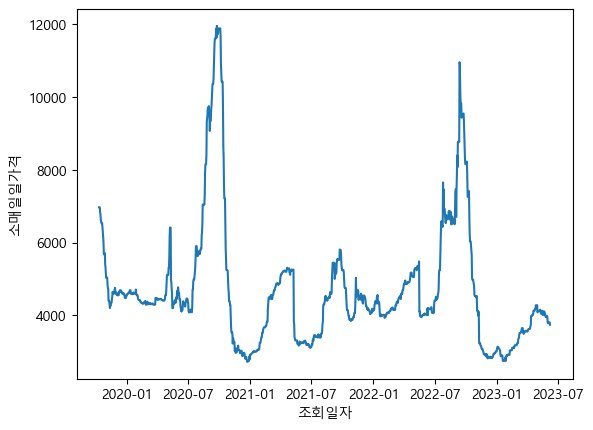

In [547]:
sns.lineplot(data=cabbage, x='조회일자', y='소매일일가격', errorbar=None)

In [549]:
vege_data=cabbage[['평균기온', '최저기온', '최고기온', '소매일일가격']]
vege_data.head()

,평균기온,최저기온,최고기온,소매일일가격
조회일자,,,,
2019-10-11,17.7,11.4,24.7,6968.0
2019-10-12,17.8,13.3,23.1,6968.0
2019-10-13,15.6,10.3,22.0,6968.0
2019-10-14,14.4,9.0,21.2,6826.0
2019-10-15,13.1,8.3,18.6,6786.0


### 정규화

In [552]:
# 정규화
min_max_scaler=MinMaxScaler()
min_max_scaled=min_max_scaler.fit_transform(vege_data)

In [554]:
train_data, test_data=train_test_split(min_max_scaled, test_size=0.2, shuffle=False)
print(train_data.shape, test_data.shape)

(1061, 4) (266, 4)


In [556]:
def make_sample(data, seq_length):
    train=[]
    target=[]

    for i in range(len(data)-seq_length):
        train.append(data[i:i+seq_length, :-1])
        target.append(data[i+seq_length, -1])
    return np.array(train), np.array(target)

In [634]:
seq_length=7

X_train, Y_train=make_sample(train_data, seq_length)
X_train.shape, Y_train.shape

((1054, 7, 3), (1054,))

### 학습

In [564]:
model=keras.Sequential()
model.add(keras.layers.Input(shape=(seq_length, 3)))                                    # LSTM 입력 크기
model.add(keras.layers.LSTM(64, activation='tanh', return_sequences=True))              # 시퀀스 중 마지막 상태만 출력 (회귀)
model.add(keras.layers.Dropout(0.2))  
model.add(keras.layers.LSTM(32, return_sequences=False))
model.add(keras.layers.Dropout(0.2))  
model.add(keras.layers.Dense(1))                                                         # 출력층
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                       │ (None, 7, 64)               │          17,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

In [570]:
def on_epoch_end_fun(epoch, logs):  
    if(epoch + 1) % 10 == 0:
       print(f"Epoch {epoch+1}: loss={logs['loss']:.4f}, mse={logs['mse']:.4f}")
        
# 각 에포크가 끝날 때 on_epoch_end 함수
print_callback=LambdaCallback(on_epoch_end=on_epoch_end_fun)

# 학습 중단
early_stopping_callback=EarlyStopping(monitor='loss',       
                                      patience=50,                # 20 epoch 동안 개선이 없으면 학습 중단
                                      verbose=1,                   # early stopping 메시지 출력
                                      restore_best_weights=True)   # 가장 좋은 가중치 복원    

In [574]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.fit(X_train, Y_train, epochs=50, batch_size=16, verbose=0, callbacks=[print_callback, early_stopping_callback])

Epoch 10: loss=0.0280, mse=0.0280
Epoch 20: loss=0.0274, mse=0.0274
Epoch 30: loss=0.0272, mse=0.0272
Epoch 40: loss=0.0269, mse=0.0269
Epoch 50: loss=0.0267, mse=0.0267
Restoring model weights from the end of the best epoch: 49.


In [580]:
X_test, Y_test=make_sample(test_data, seq_length)
pred=model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


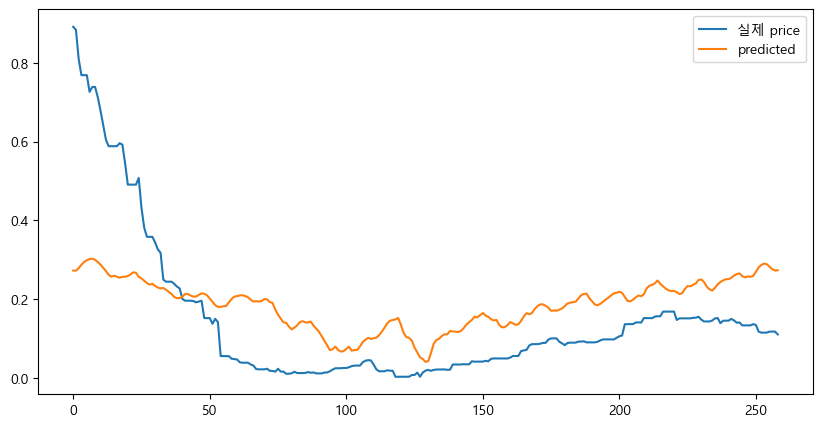

In [582]:
plt.figure(figsize=(10, 5))
plt.plot(Y_test, label='실제 price')
plt.plot(pred, label='predicted')
plt.legend()
plt.show()

In [585]:
r2=r2_score(Y_test, pred)
r2

0.2901188285111397

In [657]:
# 최근 7일 데이터를 사용해 다음날 가격 예측
last_sequence=X_test[-1:]     # 마지막 1개의 샘플, 이미 (1, 30, 1) 형태
print(last_sequence)

# 예측 수행
predicted_price=model.predict(last_sequence)
print(predicted_price)

# 원래 가격대로 변환 (역정규화)
price=np.repeat(predicted_price, 4, axis=1)  # (1, 4) 형태로 만들기

# 역정규화
price_original=min_max_scaler.inverse_transform(price)
price_original[0][3]

[[[0.77372263 0.76179245 0.74514563]
  [0.81995134 0.80188679 0.83495146]
  [0.81265207 0.75235849 0.83980583]
  [0.81995134 0.74528302 0.85194175]
  [0.81265207 0.77358491 0.81553398]
  [0.80048662 0.77122642 0.81796117]
  [0.81508516 0.78066038 0.81796117]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
[[0.27352452]]


427.35242

In [659]:
vege_data.tail(1)

,평균기온,최저기온,최고기온,소매일일가격
조회일자,,,,
2023-06-08,21.5,17.6,26.9,3742.0
